# Dakota vs Salesforce Data Clean
- USA name standardization done for both in load block
- Map state ownership for both

## Dakota Clean Up
Raw | Wirehouses | Dupe Emails | Dupe Names | Clean | AUM Aggregated

# Salesforce Clean Up
Raw | Dupe Emails | Dupe Names | Empty Emails | Clean 


# Packages

In [2]:
%pip install pandas openpyxl matplotlib 
import pandas as pd
import matplotlib.pyplot as plt
import os
import difflib
from difflib import get_close_matches

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load all files

In [3]:
dakota_df=pd.read_excel("../data/all_contacts/Dakota_All_Contacts.xlsx")
matched_contacts=pd.read_excel("../data/prospect/matched_contacts.xlsx")
matched_accounts=pd.read_excel("../data/prospect/matched_accounts.xlsx")
unmatched_contacts=pd.read_excel("../data/prospect/unmatched_contacts.xlsx")
unmatched_accounts=pd.read_excel("../data/prospect/unmatched_accounts.xlsx")

salesforce_df = pd.read_excel("../data/all_contacts/Salesforce_dataset.xlsx") # 
salesforce_618 = pd.read_excel("../data/all_contacts/Contact_SF_Extract_6_16_25.xlsx") # find out difference between this and the above


# Mutual Changes
- U.S Standardization
- Ownership Map

In [4]:
# Make a copy to track changes
original_df = salesforce_df.copy()

# Define standardization function
def standardize_country(country, state):
    if pd.isnull(country):
        country = ''
    country_upper = str(country).strip().upper()
    if country_upper in ['UNITED STATES', 'U.S.', 'USA', 'US']:
        return 'United States'
    if pd.notnull(state) and str(state).strip() != '':
        return 'United States'
    return country

# Apply standardization
for df in [dakota_df, matched_contacts, matched_accounts, unmatched_contacts, unmatched_accounts, salesforce_df, salesforce_618]:
    df['Mailing Country'] = df.apply(
    lambda row: standardize_country(row.get('Mailing Country'), row.get('Mailing State/Province')),
    axis=1
    )

In [5]:
# Define state → team member
state_team_map = {
    'AL': 'AG', 'AK': 'Rockefeller Asset Management', 'AZ': 'KH', 'AR': 'Rockefeller Asset Management',
    'CA': 'AP', 'CO': 'KH', 'CT': 'Rockefeller Asset Management', 'DE': 'KH', 'FL': 'Rockefeller Asset Management',
    'GA': 'AP', 'HI': 'Rockefeller Asset Management', 'ID': 'Rockefeller Asset Management', 'IL': 'MJ',
    'IN': 'KH', 'IA': 'Rockefeller Asset Management', 'KS': 'Rockefeller Asset Management', 'KY': 'AG',
    'LA': 'Rockefeller Asset Management', 'ME': 'Rockefeller Asset Management', 'MD': 'KH', 'MA': 'AP',
    'MI': 'KH', 'MN': 'Rockefeller Asset Management', 'MS': 'Rockefeller Asset Management', 'MO': 'AG',
    'MT': 'Rockefeller Asset Management', 'NE': 'Rockefeller Asset Management', 'NV': 'Rockefeller Asset Management',
    'NH': 'Rockefeller Asset Management', 'NJ': 'KH', 'NM': 'KH', 'NY': 'AG', 'NC': 'AG', 'ND': 'Rockefeller Asset Management',
    'OH': 'KH', 'OK': 'Rockefeller Asset Management', 'OR': 'Rockefeller Asset Management', 'PA': 'KH',
    'RI': 'Rockefeller Asset Management', 'SC': 'AG', 'SD': 'Rockefeller Asset Management', 'TN': 'AG',
    'TX': 'MJ', 'UT': 'KH', 'VT': 'Rockefeller Asset Management', 'VA': 'KH', 'WA': 'Rockefeller Asset Management',
    'WV': 'Rockefeller Asset Management', 'WI': 'MJ', 'WY': 'Rockefeller Asset Management', 'DC': 'KH'
}

# Define team member → OwnerID
team_ownerID_map = {
    'AG': '005a600000177CHAAY',
    'Rockefeller Asset Management': '005a6000005CXtNAAW',
    'KH': '005a6000000c1j8AAA',
    'AP': '005a6000000c1jDAAQ',
    'MJ': '005a60000043nujAAA'
}

# Example: apply to a list of dataframes
dataframes = {
    "dakota_df": dakota_df,
    "matched_contacts": matched_contacts,
    "matched_accounts": matched_accounts,
    "unmatched_contacts": unmatched_contacts,
    "unmatched_accounts": unmatched_accounts,
    "salesforce_df": salesforce_df,
    "salesforce_618": salesforce_618
}

for name, df in dataframes.items():
    if 'Company Owner' not in df.columns:
        df['Company Owner'] = None
    if 'Mailing State/Province' in df.columns:
        df['Company Owner'] = df.apply(
            lambda row: state_team_map.get(row['Mailing State/Province'], row['Company Owner'])
            if pd.isna(row['Company Owner']) else row['Company Owner'],
            axis=1
        )
    df['OwnerID'] = df['Company Owner'].map(team_ownerID_map)


# Dakota Analysis

In [6]:
# Total entries
total_entries = len(dakota_df)

# Identify blank emails
dakota_blanks = dakota_df[dakota_df['Email'].isna() | (dakota_df['Email'].astype(str).str.strip() == '')]

# Identify duplicate emails (excluding blanks)
non_blank_df = dakota_df[~dakota_df['Email'].isna() & (dakota_df['Email'].astype(str).str.strip() != '')]
dakota_dupes = non_blank_df[non_blank_df.duplicated(subset='Email', keep=False)]

# Cleaned data (excluding blanks and duplicates)
dakotaclean_1_1 = dakota_df.drop(index=dakota_blanks.index.union(dakota_dupes.index))

# Counts
num_blank = len(dakota_blanks)
num_duplicates = len(dakota_dupes)
num_cleaned = len(dakotaclean_1_1)

# Print summary
print("Summary:")
print(f"Total entries: {total_entries}")
print(f"Blank emails: {num_blank}")
print(f"Duplicate emails (non-blank): {num_duplicates}")
print(f"Cleaned entries: {num_cleaned}")

# Save blanks and duplicates to separate Excel files
output_dir = "../data/dakota_salesforce_sheets"
os.makedirs(output_dir, exist_ok=True)

dakota_blanks.to_excel(os.path.join(output_dir, "Dakota_Blanks.xlsx"), index=False)
dakota_dupes.to_excel(os.path.join(output_dir, "Dakota_Duplicates.xlsx"), index=False)



Summary:
Total entries: 167025
Blank emails: 10855
Duplicate emails (non-blank): 3804
Cleaned entries: 152366


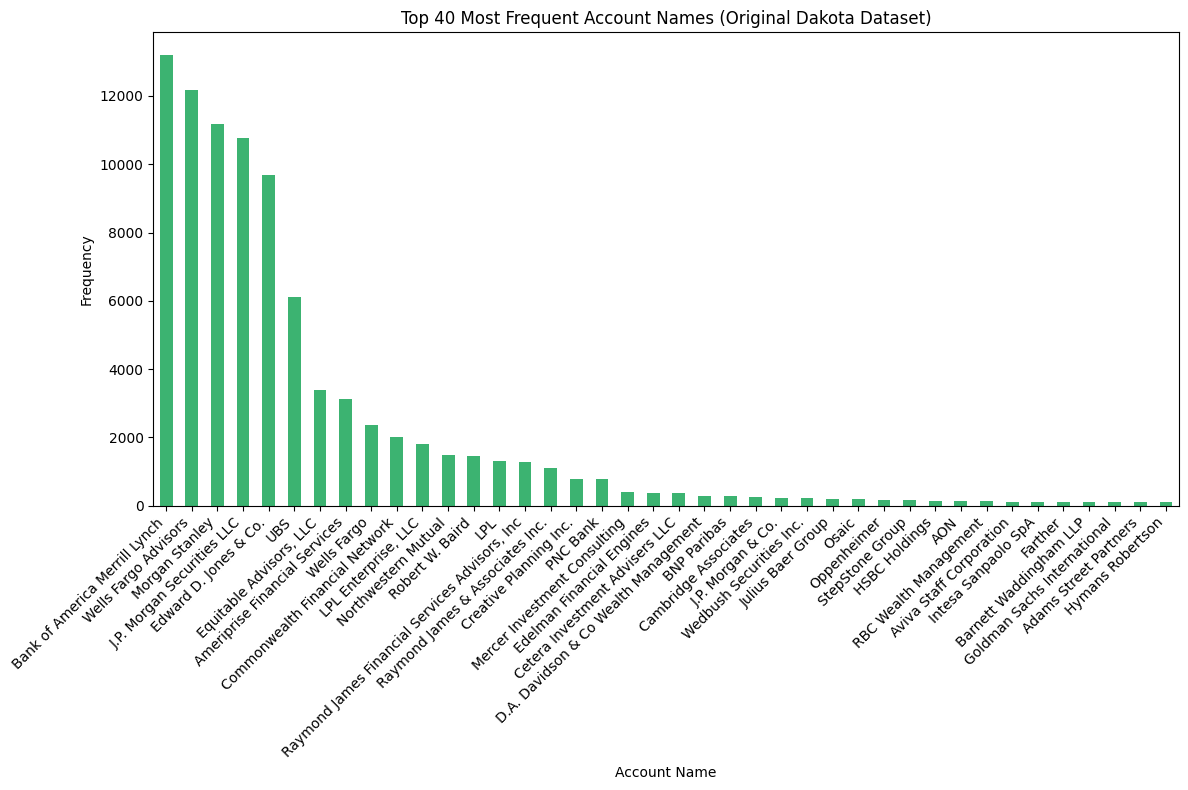

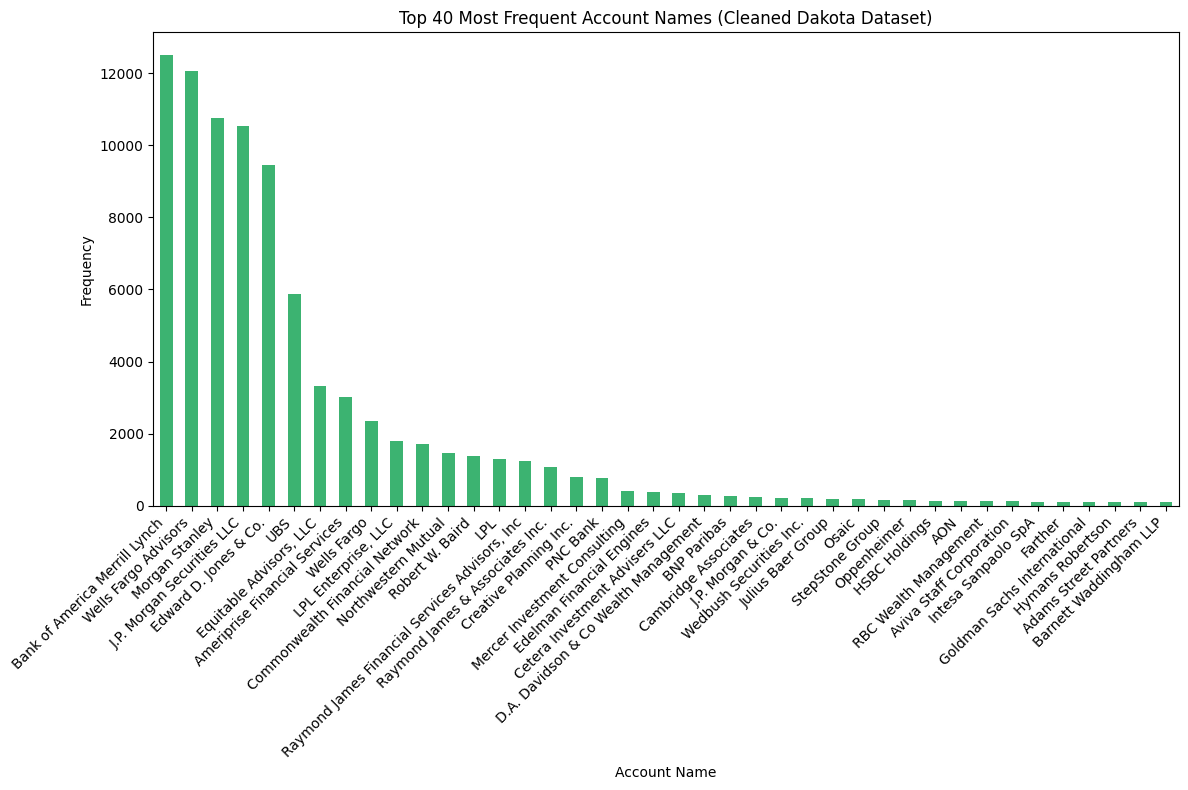

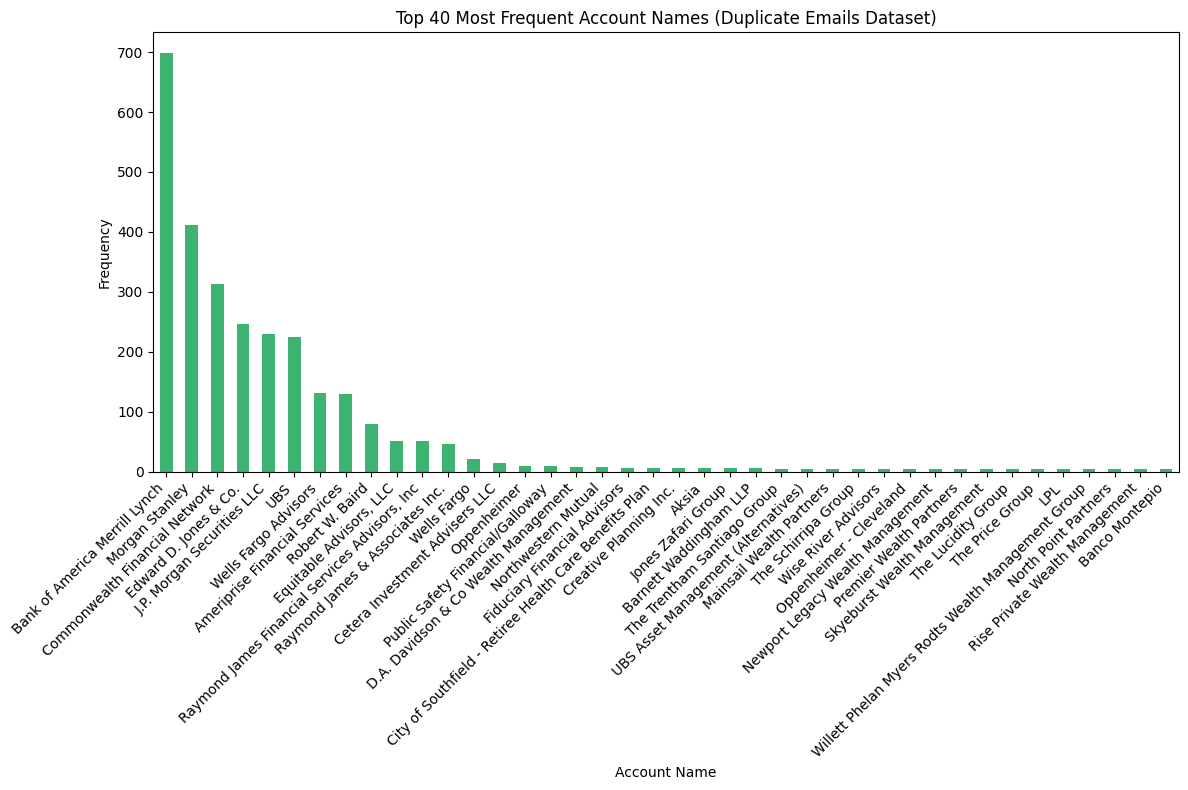

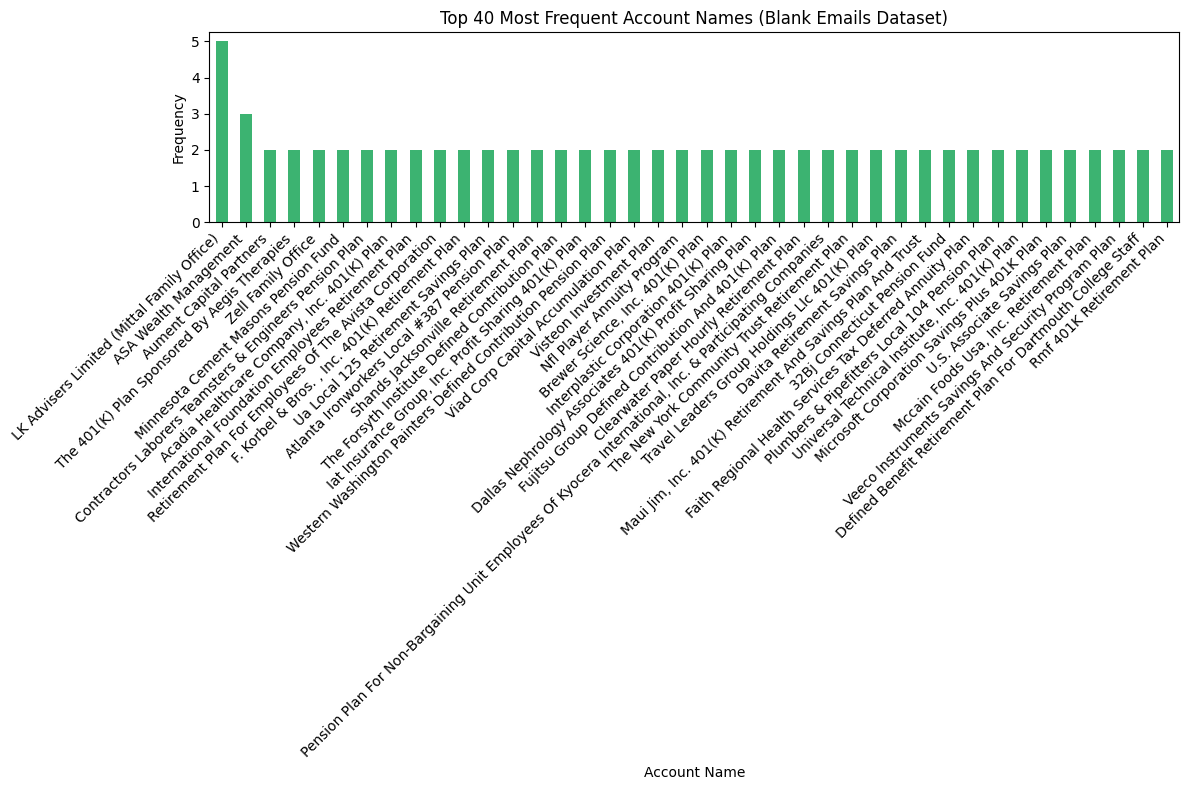

In [7]:
# Dictionary of DataFrames
dataframes = {
    "Original Dakota Dataset": dakota_df,
    "Cleaned Dakota Dataset": dakotaclean_1_1,
    "Duplicate Emails Dataset": dakota_dupes,
    "Blank Emails Dataset": dakota_blanks
}

# Generate bar plots
for title, df in dataframes.items():
    if 'Account Name' in df.columns:
        account_counts = df['Account Name'].value_counts().head(40)
        plt.figure(figsize=(12, 8))
        account_counts.plot(kind='bar', color='mediumseagreen')
        plt.title(f"Top 40 Most Frequent Account Names ({title})")
        plt.xlabel('Account Name')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()



# Wirehouse List

In [8]:
# Define the wirehouse map
wirehouse_map = {
    'Bank of America Merrill Lynch': 'Merrill Lynch',
    'Wells Fargo Advisors LLC': 'Wells Fargo',
    'Morgan Stanley & Co.': 'Morgan Stanley',
    'J.P. Morgan Securities LLC': 'J.P. Morgan',
    'UBS Financial Services Inc.': 'UBS',
    'Ameriprise Financial Services Inc.': 'Ameriprise',
    'Raymond James Financial Services Inc.': 'Raymond James',
    'Goldman Sachs & Co. LLC': 'Goldman Sachs',
    'UBS': 'UBS',
    'Morgan Stanley': 'Morgan Stanley',
    'Wells Fargo Advisors': 'Wells Fargo',
    'Wells Fargo': 'Wells Fargo',
    'Ameriprise Financial Services': 'Ameriprise',
    'Goldman Sachs International': 'Goldman Sachs',
    'Raymond James Financial Services Advisors, Inc': 'Raymond James',
    'Raymond James & Associates Inc.': 'Raymond James',
    'J.P. Morgan & Co.': 'J.P. Morgan',
    'BlackRock': 'BlackRock',
    'Edward D. Jones': 'Edward Jones',
    'BlackRock Alternative Investors': 'BlackRock',
    'BlackRock Alternative Investors (BAI)': 'BlackRock'
}

# Normalize account names
dakotaclean_1_1['Account Name'] = dakotaclean_1_1['Account Name'].astype(str).str.strip().str.lower()
normalized_map = {k.lower(): v for k, v in wirehouse_map.items()}

# Fuzzy match function
def match_wirehouse(name):
    matches = difflib.get_close_matches(name, normalized_map.keys(), n=1, cutoff=0.6)
    return normalized_map[matches[0]] if matches else None

# Apply fuzzy matching
dakotaclean_1_1['wirehouse_group'] = dakotaclean_1_1['Account Name'].apply(match_wirehouse)

# Count and display results
print(f"Total number of account entries: {dakotaclean_1_1['Account Name'].count()}")
print(f"Total number of unique accounts: {dakotaclean_1_1['Account Name'].nunique()}")
print("\nWirehouse group counts:")
print(dakotaclean_1_1['wirehouse_group'].value_counts(dropna=False))


Total number of account entries: 152366
Total number of unique accounts: 18570

Wirehouse group counts:
wirehouse_group
None              75517
Wells Fargo       19384
Merrill Lynch     12504
Morgan Stanley    10845
J.P. Morgan       10807
Edward Jones       9451
UBS                6549
Ameriprise         3923
Raymond James      2879
Goldman Sachs       270
BlackRock           237
Name: count, dtype: int64


# Splitting Wirehouse Datasets from Main

Summary Statistics:
Number of unique emails left: 75517
Number of unique account names left: 17536
Number of duplicate emails: 0

Account Totals:
Total accounts at start: 152366
Wirehouses removed: 76849
Total accounts left: 75517


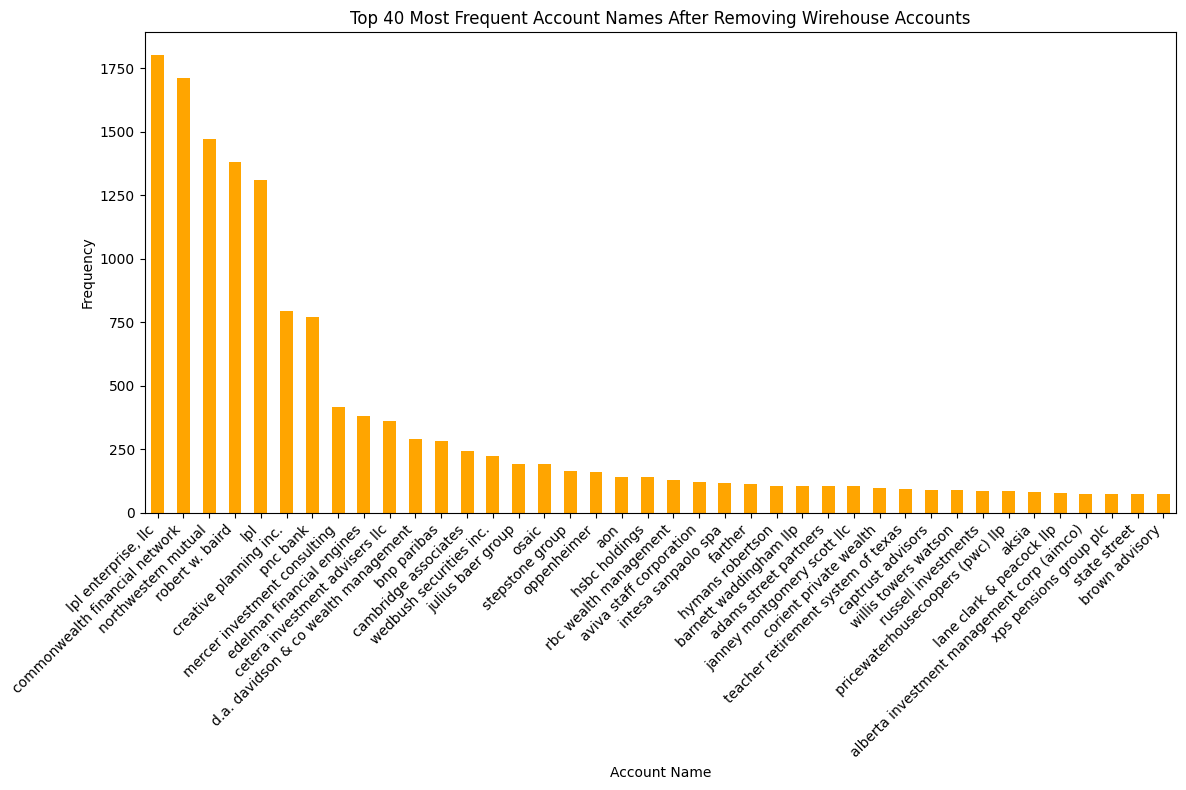

In [9]:
# Total accounts at start
total_accounts_start = len(dakotaclean_1_1)

# Split into wirehouse and non-wirehouse groups
dakota_wirehouses = dakotaclean_1_1[dakotaclean_1_1['wirehouse_group'].notna()].copy()
dakota_non_wirehouse_df = dakotaclean_1_1[dakotaclean_1_1['wirehouse_group'].isna()].copy()

# Count wirehouses removed and accounts left
wirehouses_removed = len(dakota_wirehouses)
total_accounts_left = len(dakota_non_wirehouse_df)

# Output directory
output_dir = "../data/dakota_salesforce_sheets"
os.makedirs(output_dir, exist_ok=True)

# Save the wirehouse and non-wirehouse datasets
dakota_wirehouses.to_excel(os.path.join(output_dir, "Dakota_Wirehouses.xlsx"), index=False)
dakota_non_wirehouse_df.to_excel(os.path.join(output_dir, "Dakota_Clean_2.xlsx"), index=False)

# Summary stats
num_unique_emails = dakota_non_wirehouse_df['Email'].nunique()
num_unique_accounts = dakota_non_wirehouse_df['Account Name'].nunique()
num_duplicate_emails = dakota_non_wirehouse_df['Email'].duplicated().sum()

print("Summary Statistics:")
print(f"Number of unique emails left: {num_unique_emails}")
print(f"Number of unique account names left: {num_unique_accounts}")
print(f"Number of duplicate emails: {num_duplicate_emails}")

print("\nAccount Totals:")
print(f"Total accounts at start: {total_accounts_start}")
print(f"Wirehouses removed: {wirehouses_removed}")
print(f"Total accounts left: {total_accounts_left}")

# Plot top 40 remaining accounts
top_40_accounts = dakota_non_wirehouse_df['Account Name'].value_counts().head(40)
plt.figure(figsize=(12, 8))
top_40_accounts.plot(kind='bar', color='orange')
plt.title('Top 40 Most Frequent Account Names After Removing Wirehouse Accounts')
plt.xlabel('Account Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Dakota AUM Data

In [10]:
# Checking AUM Data for dupes
matched_accounts["Provided Account ID"] = matched_accounts["Provided Account ID"].str.strip().str.upper()
matched_contacts["Provided Salesforce Contact Account Record ID"] = matched_contacts["Provided Salesforce Contact Account Record ID"].str.strip().str.upper()
print(matched_contacts["Provided Salesforce Contact Account Record ID"].isnull().sum())
print(matched_accounts["Provided Account ID"].isnull().sum())



0
0


### Matching AUM Data
- Output only matched account IDs across 4 files

    - matched contacts
    - matched accounts
    - unmatched contacts
    - unmatched accounts

In [11]:
# Define file paths
matched_accounts_path = "../data/prospect/matched_accounts.xlsx"
matched_contacts_path = "../data/prospect/matched_contacts.xlsx"
unmatched_accounts_path = "../data/prospect/unmatched_accounts.xlsx"
unmatched_contacts_path = "../data/prospect/unmatched_contacts.xlsx"

output_dir = "../data/dakota_salesforce_sheets"
os.makedirs(output_dir, exist_ok=True)

# Load matched datasets
matched_accounts = pd.read_excel(matched_accounts_path, engine='openpyxl')
matched_contacts = pd.read_excel(matched_contacts_path, engine='openpyxl')

# Merge matched accounts and contacts
aum_matched = pd.merge(
    matched_accounts,
    matched_contacts,
    left_on="Provided Account ID",
    right_on="Provided Salesforce Contact Account Record ID",
    how="inner"
)

# Save matched results
aum_matched.to_excel(os.path.join(output_dir, "AUM_matched.xlsx"), index=False)

# Load unmatched datasets
unmatched_accounts = pd.read_excel(unmatched_accounts_path, engine='openpyxl')
unmatched_contacts = pd.read_excel(unmatched_contacts_path, engine='openpyxl')

# Attempt to match unmatched contacts to unmatched accounts
aum_unmatched = pd.merge(
    unmatched_accounts,
    unmatched_contacts,
    on="Account ID (Case Safe)",
    how="inner"
)

# Save unmatched results
aum_unmatched.to_excel(os.path.join(output_dir, "AUM_unmatched.xlsx"), index=False)

# Print match statistics
match_percentage = (len(aum_matched) / len(matched_contacts)) * 100
print(f"Matched contacts: {len(aum_matched)}")
print(f"Match rate: {match_percentage:.2f}%")

unmatch_percentage = (len(aum_unmatched) / len(unmatched_contacts)) * 100
print(f"Unmatched contacts matched to accounts: {len(aum_unmatched)}")
print(f"Unmatched match rate: {unmatch_percentage:.2f}%")

# Count total contacts
total_contacts = len(aum_matched)
print(f"Total matched contacts: {total_contacts}")

# Count NaN values per column
nan_summary = aum_matched.isna().sum()
print("\nNaN count per column:")
print(nan_summary)



Matched contacts: 16927
Match rate: 92.12%
Unmatched contacts matched to accounts: 69419
Unmatched match rate: 41.56%
Total matched contacts: 16927

NaN count per column:
Provided Account ID                                  0
Provided Account Name                                0
Provided Firm ID                                 16092
Provided BillingStreet                           12808
Provided Billing City                            11098
                                                 ...  
Dakota Last Modified Date/Time (DATALOADER)_y        0
Dakota Created Date/Time (DATALOADER)_y              0
Dakota Status_y                                      0
Matching Criteria_y                                  0
Duplicates_y                                         0
Length: 122, dtype: int64


In [12]:
print(aum_matched.columns.tolist())


['Provided Account ID', 'Provided Account Name', 'Provided Firm ID', 'Provided BillingStreet', 'Provided Billing City', 'Provided BillingCountry', 'Provided BillingPostalCode', 'Provided Website', 'Provided CRD', 'Dakota Account ID (Case Safe)_x', 'Dakota Account Name_x', 'Dakota Type', 'Dakota AUM', 'Dakota Metro Area', 'Dakota Parent Account', 'Dakota Website', 'Dakota Phone_x', 'Dakota CRD#', 'Dakota Billing Street', 'Dakota Billing City', 'Dakota Billing State/Province', 'Dakota Billing Zip/Postal Code', 'Dakota Billing Country', 'Dakota Description', 'Dakota Platform Description', 'Dakota Research Team Overview', 'Dakota Opportunity Description', 'Dakota Custodian(s)', 'Dakota UHNW Division', 'Dakota TAMP', 'Dakota Sub-Advised MF Family', 'Dakota Select Lists', 'Dakota OCIO Business', 'Dakota Models', 'Dakota Client Base', 'Dakota Emerging Manager Program', 'Dakota Invests in Impact, SRI or ESG', 'Dakota Preferred Investment Vehicle', 'Dakota Mutual Fund Usage', 'Dakota LP Usage',

Final Dataset for AUM Structure:

Provided Account ID | Provided Account Name | Provided Firm ID | Provided BillingStreet | Provided Billing City | Provided BillingCountry | Provided BillingPostalCode | Provided Website | Provided CRD | Dakota Account ID (Case Safe)_x | Dakota Account Name_x	| Dakota Type | Dakota AUM | Dakota Metro Area | Dakota Parent Account | Dakota Website	Dakota | Phone_x | Dakota CRD# | Dakota Billing Street | Dakota Billing City | Dakota Billing State/Province | Dakota Billing Zip/Postal Code | Dakota Billing Country | Dakota Description | Dakota Platform Description | Dakota Research Team Overview | Dakota Opportunity Description | Dakota Custodian(s) | Dakota UHNW Division | Dakota TAMP | Dakota Sub-Advised MF Family | Dakota Select Lists | Dakota OCIO Business | Dakota Models | Dakota Client Base | Dakota Emerging Manager Program | Dakota Invests in Impact, SRI or ESG | Dakota Preferred Investment Vehicle | Dakota Mutual Fund Usage | Dakota LP Usage | Dakota Separate Account Usage | Dakota RIC Usage | Dakota UMA Usage | Dakota ETF Usage | Dakota CIT Usage | Dakota UCITS Usage | Dakota Hedge FOF | Dakota Real Estate FOF | Dakota Private Equity FOF	Dakota General Consultant | Dakota General Consultant 2	| Dakota Hedge Fund Consultant | Dakota Real Estate Consultant | Dakota Private Equity Consultant | Dakota Small Cap Equities | Dakota Mid Cap Equities	Dakota Large Cap Equities | Dakota Micro Cap US Equities | Dakota International Equities |	Dakota Emerging Market Equities | Dakota Global Equities | Dakota Municipal Bonds | Dakota Core Bonds | Dakota Emerging Market Bonds | Dakota High Yield Bonds | Dakota Government Bonds | Dakota Bank Loans | Dakota Unconstrained	Dakota MBS | Dakota CMBS | Dakota Convertibles | Dakota Private Equity | Dakota Private Credit | Dakota Hedge Funds | Dakota Private Real Estate | Dakota Liquid Alternatives | Dakota Real Assets | Dakota Venture Capital | Dakota Alternative Platform Description | Dakota Last Modified Date/Time | Dakota Created Date/Time | Dakota Last Modified Date/Time (DATALOADER)_x | Dakota Created Date/Time (DATALOADER)_x | Dakota Status_x | Matching Criteria_x | Duplicates_x | Provided Contact ID | Provided Salesforce Contact Account Record ID | Provided First Name | Provided Last Name | Provided Email | Provided Phone | Provided MailingStreet | Provided MailingCity | Provided MailingState | Provided MailingCountry | Provided MailingPostalCode | Dakota ContactID |	Dakota First Name | Dakota Last Name | Dakota Email | Dakota Account ID (Case Safe)_y | Dakota Account Name_y | Dakota Metro Area: Metro Area Name | Dakota Phone_y | Dakota Title | Dakota Contact Type | Dakota Asset Class Coverage | Dakota Mailing Street | Dakota Mailing City | Dakota Mailing State/Province | Dakota Mailing Zip/Postal Code | Dakota Mailing Country | Dakota Biography | Dakota CRD # | Dakota Last Modified DateTime | Dakota Created DateTime | Dakota Last Modified Date/Time (DATALOADER)_y | Dakota Created Date/Time (DATALOADER)_y | Dakota Status_y | Matching Criteria_y | Duplicates_y | Converted?



# Matching win list to labeled dataset
- Of the historical wins, what % can be mapped to labels?
- 'Provided Account Name' - 'Potential Client'

In [29]:
# Load the labeled AUM dataset
aum_labeled = pd.read_excel("../data/dakota_salesforce_sheets/AUM_labeled.xlsx", engine='openpyxl')

# Convert Yes/No columns to binary 1/0
yes_no_columns = [
    'Provided CRD', 'Dakota Select Lists', 'Dakota OCIO Business', 'Dakota Models',
    'Dakota Emerging Manager Program', 'Dakota Invests in Impact, SRI or ESG',
    'Dakota Hedge FOF', 'Dakota Real Estate FOF', 'Dakota Private Equity FOF',
    'Dakota Micro Cap US Equities', 'Dakota Private Equity', 'Dakota Private Credit',
    'Dakota Hedge Funds', 'Dakota Private Real Estate', 'Dakota Liquid Alternatives',
    'Dakota Real Assets', 'Dakota Venture Capital'
]
aum_labeled[yes_no_columns] = aum_labeled[yes_no_columns].replace({'Yes': 1, 'No': 0})

# Define strategy mapping
strategy_map = {
    'Active': 1,
    'Passive': 2,
    'Active/Passive': 0,
    'In-House': 3,
    'Yes': 1,
    'No': 0
}

# Strategy columns to convert
strategy_columns = [
    'Dakota Small Cap Equities', 'Dakota Mid Cap Equities', 'Dakota Large Cap Equities',
    'Dakota International Equities', 'Dakota Emerging Market Equities', 'Dakota Global Equities',
    'Dakota Municipal Bonds', 'Dakota Core Bonds', 'Dakota Emerging Market Bonds',
    'Dakota High Yield Bonds', 'Dakota Government Bonds', 'Dakota Bank Loans',
    'Dakota Unconstrained', 'Dakota MBS', 'Dakota CMBS', 'Dakota Convertibles',
    'Dakota Status_x', 'Dakota Status_y'
]

# Mapping for Dakota Preferred Investment Vehicle
vehicle_map = {
    'Mutual Funds': 1,
    'ETFs': 2,
    'Separate Accounts': 3,
    'LP': 4,
    'Hedge Funds': 5,
    'Subadvisory': 6
}

# Mapping for usage levels
usage_map = {
    'Zero': 0,
    'Small': 1,
    'Medium': 2,
    'Large': 3
}

# Apply vehicle mapping
vehicle_col = 'Dakota Preferred Investment Vehicle'
unmapped_vehicles = aum_labeled[vehicle_col].dropna().astype(str).str.strip().unique()
unmapped_vehicles = [val for val in unmapped_vehicles if val not in vehicle_map]
aum_labeled[vehicle_col] = aum_labeled[vehicle_col].replace(vehicle_map)

# Apply usage mapping
usage_columns = [
    'Dakota Mutual Fund Usage', 'Dakota LP Usage', 'Dakota Separate Account Usage',
    'Dakota RIC Usage', 'Dakota UMA Usage', 'Dakota ETF Usage',
    'Dakota CIT Usage', 'Dakota UCITS Usage'
]

unmapped_usage = {}
for col in usage_columns:
    unique_vals = aum_labeled[col].dropna().astype(str).str.strip().unique()
    unmapped = [val for val in unique_vals if val not in usage_map]
    if unmapped:
        unmapped_usage[col] = unmapped
    aum_labeled[col] = aum_labeled[col].replace(usage_map)

# Save the updated dataset
aum_labeled.to_excel("../data/dakota_salesforce_sheets/AUM_labeled.xlsx", index=False)

# Track unmapped values
unmapped_values = {}

# Apply strategy mapping and collect unmapped values
for col in strategy_columns:
    unique_vals = aum_labeled[col].dropna().astype(str).str.strip().unique()
    unmapped = [val for val in unique_vals if val not in strategy_map]
    if unmapped:
        unmapped_values[col] = unmapped
    aum_labeled[col] = aum_labeled[col].replace(strategy_map)

# Save the updated dataset
aum_labeled.to_excel("../data/dakota_salesforce_sheets/AUM_labeled.xlsx", index=False)

# Output summary
print("Converted Yes/No columns to binary:", yes_no_columns)
print("Converted strategy columns:", strategy_columns)
print("Unmapped values found in strategy columns:")
for col, vals in unmapped_values.items():
    print(f"{col}: {vals}")

print("Unmapped values in 'Dakota Preferred Investment Vehicle':", unmapped_vehicles)
print("Unmapped values in usage columns:")
for col, vals in unmapped_usage.items():
    print(f"{col}: {vals}")

C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_49472\115413675.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aum_labeled[vehicle_col] = aum_labeled[vehicle_col].replace(vehicle_map)
C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_49472\115413675.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aum_labeled[col] = aum_labeled[col].replace(usage_map)
C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_49472\115413675.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future ve

Converted Yes/No columns to binary: ['Provided CRD', 'Dakota Select Lists', 'Dakota OCIO Business', 'Dakota Models', 'Dakota Emerging Manager Program', 'Dakota Invests in Impact, SRI or ESG', 'Dakota Hedge FOF', 'Dakota Real Estate FOF', 'Dakota Private Equity FOF', 'Dakota Micro Cap US Equities', 'Dakota Private Equity', 'Dakota Private Credit', 'Dakota Hedge Funds', 'Dakota Private Real Estate', 'Dakota Liquid Alternatives', 'Dakota Real Assets', 'Dakota Venture Capital']
Converted strategy columns: ['Dakota Small Cap Equities', 'Dakota Mid Cap Equities', 'Dakota Large Cap Equities', 'Dakota International Equities', 'Dakota Emerging Market Equities', 'Dakota Global Equities', 'Dakota Municipal Bonds', 'Dakota Core Bonds', 'Dakota Emerging Market Bonds', 'Dakota High Yield Bonds', 'Dakota Government Bonds', 'Dakota Bank Loans', 'Dakota Unconstrained', 'Dakota MBS', 'Dakota CMBS', 'Dakota Convertibles', 'Dakota Status_x', 'Dakota Status_y']
Unmapped values found in strategy columns:
Da

---
---
---

# Salesforce Data Analysis

In [ ]:
# General info
print(salesforce_df.info())

# Summary statistics for all columns
print(salesforce_df.describe(include='all'))

# Check for and display duplicate rows
duplicates = salesforce_df[salesforce_df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

# Drop duplicates if needed
salesforce_df = salesforce_df.drop_duplicates(subset='Email')

# Count missing values per column
missing = salesforce_df.isnull().sum()
print("Missing values per column:\n", missing)

# Top job titles
print("Top Titles:\n", salesforce_df['Title'].value_counts().head(10))

# Top states/provinces
print("Top Mailing States/Provinces:\n", salesforce_df['Mailing State/Province'].value_counts().head(10))

# Top email domains
email_domains = salesforce_df['Email'].dropna().apply(lambda x: x.split('@')[-1])
print("Top Email Domains:\n", email_domains.value_counts().head(10))

# Top company owners
print("Top Company Owners:\n", salesforce_df['Company Owner'].value_counts().head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48678 entries, 0 to 48677
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Salutation               18 non-null     object
 1   First Name               48565 non-null  object
 2   Last Name                48677 non-null  object
 3   Title                    45616 non-null  object
 4   Company Name             48678 non-null  object
 5   Mailing Street           36937 non-null  object
 6   Mailing City             46832 non-null  object
 7   Mailing State/Province   45583 non-null  object
 8   Mailing Zip/Postal Code  25401 non-null  object
 9   Mailing Country          48678 non-null  object
 10  Phone                    41363 non-null  object
 11  Fax                      15929 non-null  object
 12  Mobile                   5 non-null      object
 13  Email                    38814 non-null  object
 14  Company Owner            48678 non-nul

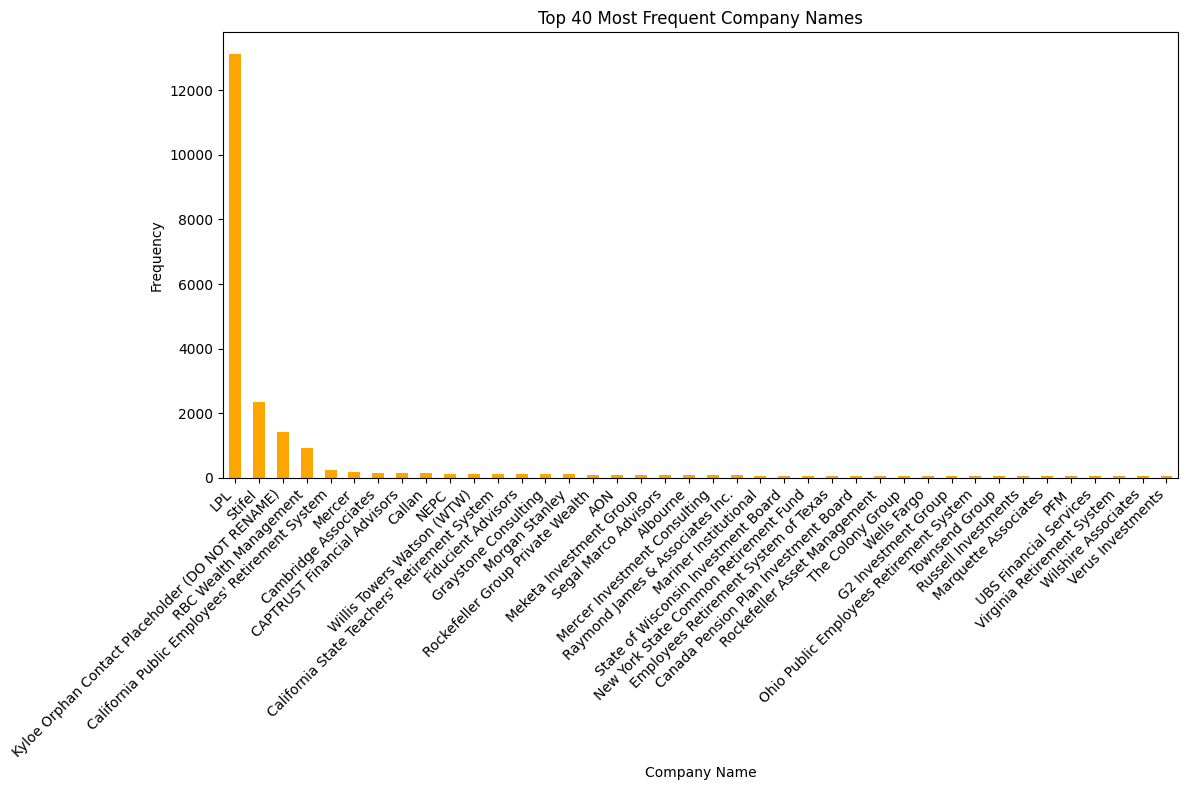

In [ ]:
# Get top 40 most frequent company names
top_40_companies = salesforce_df['Company Name'].value_counts().head(40)

# Plot
plt.figure(figsize=(12, 8))
top_40_companies.plot(kind='bar', color='orange')
plt.title('Top 40 Most Frequent Company Names')
plt.xlabel('Company Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

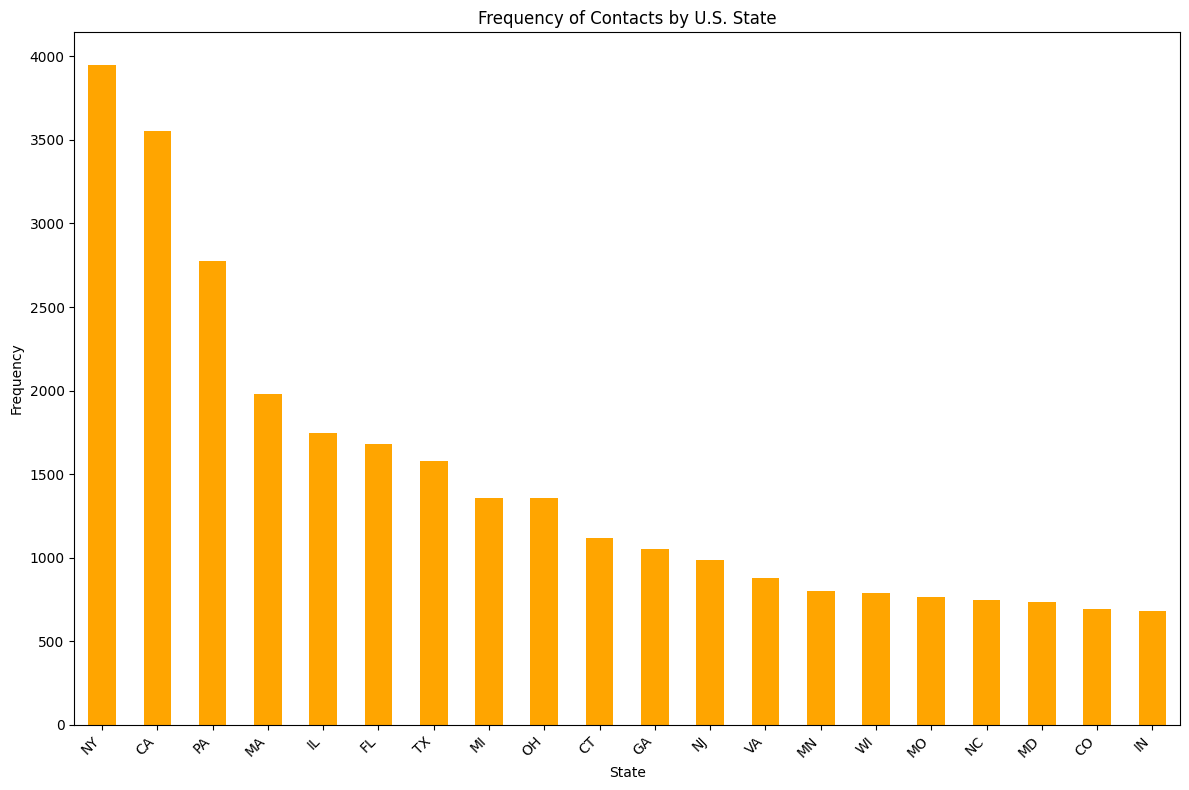

In [ ]:
# Top 20 states by contact frequency
state_counts = salesforce_df['Mailing State/Province'].value_counts().head(20)

plt.figure(figsize=(12, 8))
state_counts.plot(kind='bar', color='orange')
plt.title('Frequency of Contacts by U.S. State')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

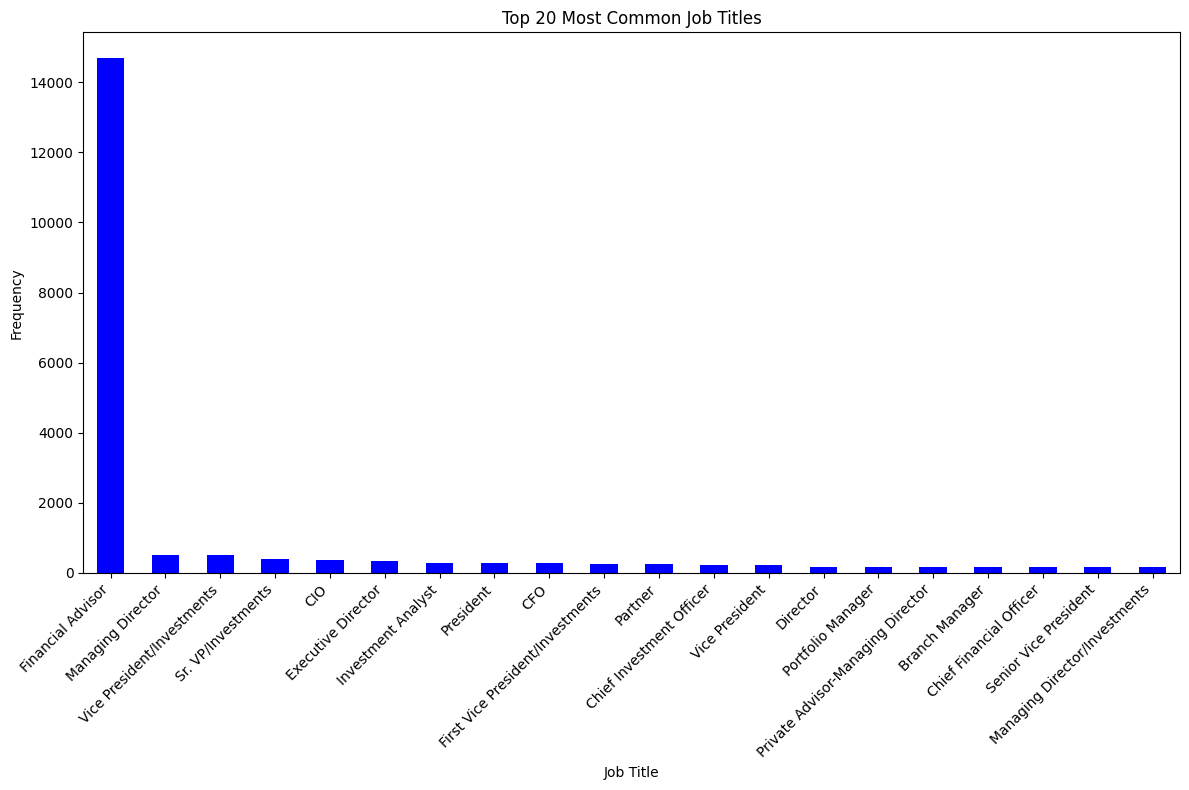

In [83]:
# Get top 20 job titles
top_20_titles = salesforce_df['Title'].value_counts().head(20)

# Plot
plt.figure(figsize=(12, 8))
top_20_titles.plot(kind='bar', color='blue')
plt.title('Top 20 Most Common Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Filtering out Wirehouses from Salesforce

In [84]:
# Normalize company names
salesforce_df['Company Name'] = salesforce_df['Company Name'].str.strip().str.lower()
normalized_map = {k.lower(): v for k, v in wirehouse_map.items()}

# Fuzzy match function
def match_wirehouse(name):
    matches = difflib.get_close_matches(name, normalized_map.keys(), n=1, cutoff=0.6)
    return normalized_map[matches[0]] if matches else None

# Apply fuzzy matching
salesforce_df['wirehouse_group'] = salesforce_df['Company Name'].apply(match_wirehouse)

# Count wirehouse firms
wirehouse_counts = salesforce_df['wirehouse_group'].value_counts()

# Add total row
wirehouse_counts.loc['Total'] = wirehouse_counts.sum()

# Display result
print("Wirehouse firms count:\n", wirehouse_counts)

# Create wirehouse and non-wirehouse DataFrames
wirehouse_df = salesforce_df[salesforce_df['wirehouse_group'].notnull()].copy()
salesforce_non_wirehouse_df = salesforce_df[salesforce_df['wirehouse_group'].isnull()].copy()

# Optional: print counts
print(f"Wirehouse contacts: {len(wirehouse_df)}")
print(f"Non-wirehouse contacts: {len(salesforce_non_wirehouse_df)}")

Wirehouse firms count:
 wirehouse_group
Wells Fargo        398
Ameriprise         189
Raymond James      136
UBS                124
Morgan Stanley     117
Merrill Lynch       66
Goldman Sachs       48
J.P. Morgan         45
BlackRock           42
Edward Jones        12
Total             1177
Name: count, dtype: int64
Wirehouse contacts: 1177
Non-wirehouse contacts: 37629


# Non Wirehouse Dakota X Salesforce Match
- Compare and contrast
- Match with Dakota overriding uncertain salesforce bits

--- Dakota Non-Wirehouse Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 76461 entries, 0 to 167024
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ContactID                    76461 non-null  object
 1   First Name                   76431 non-null  object
 2   Last Name                    76461 non-null  object
 3   Email                        76460 non-null  object
 4   Account ID (Case Safe)       76461 non-null  object
 5   Account Name                 76461 non-null  object
 6   Metro Area: Metro Area Name  76439 non-null  object
 7   Phone                        75640 non-null  object
 8   Title                        76457 non-null  object
 9   Contact Type                 76453 non-null  object
 10  Asset Class Coverage         76438 non-null  object
 11  Mailing Street               75938 non-null  object
 12  Mailing City                 76441 non-null  object
 13  M

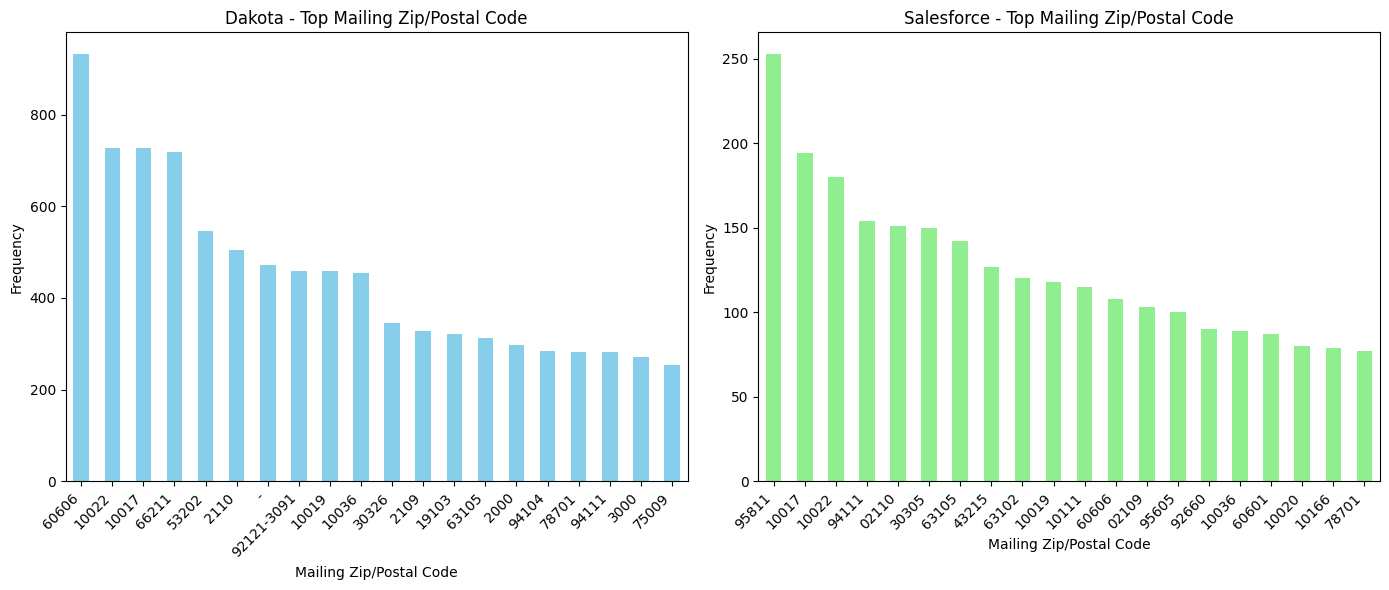

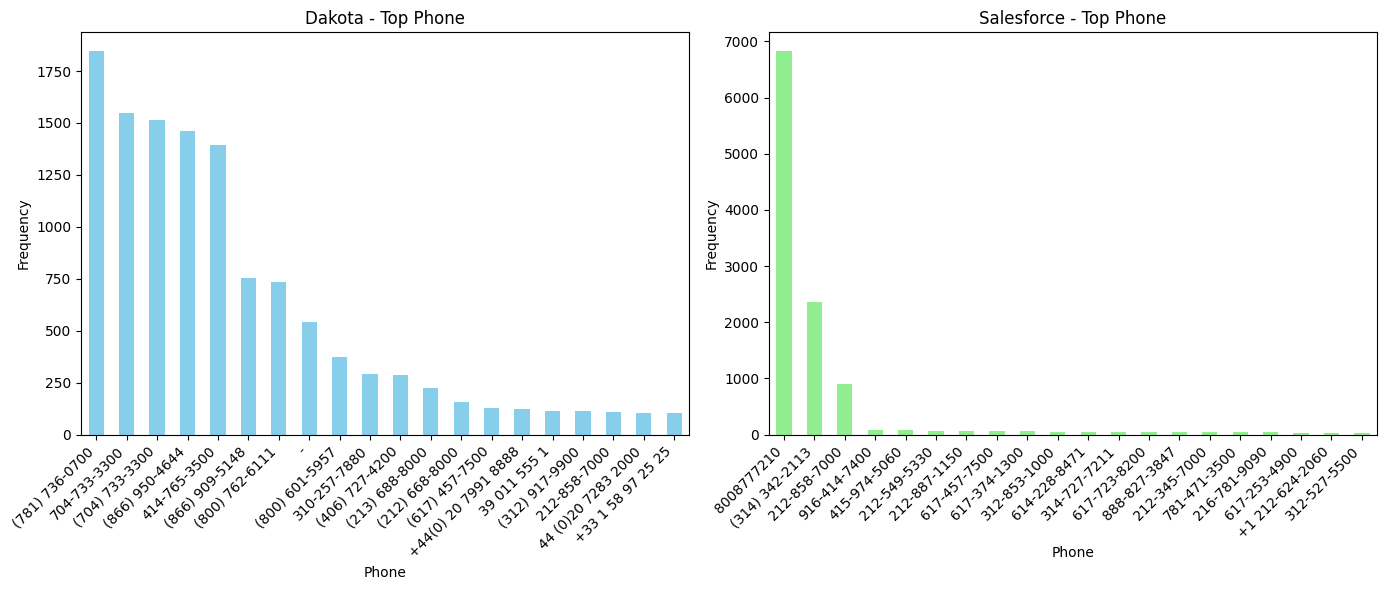

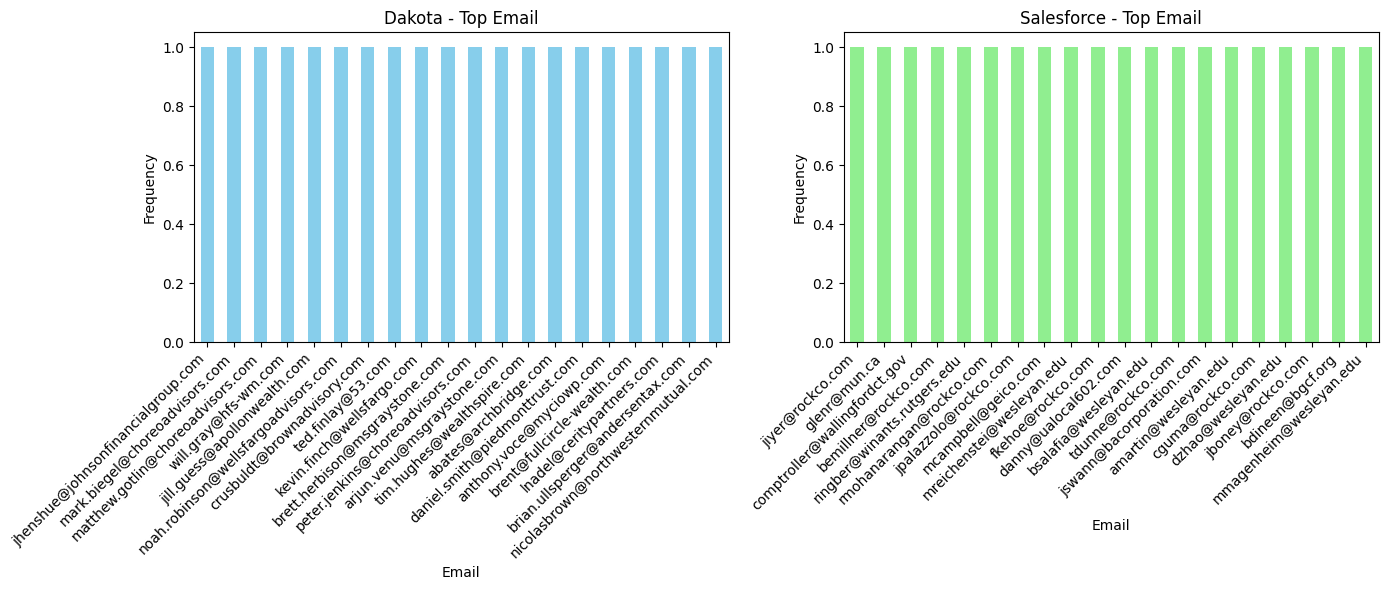

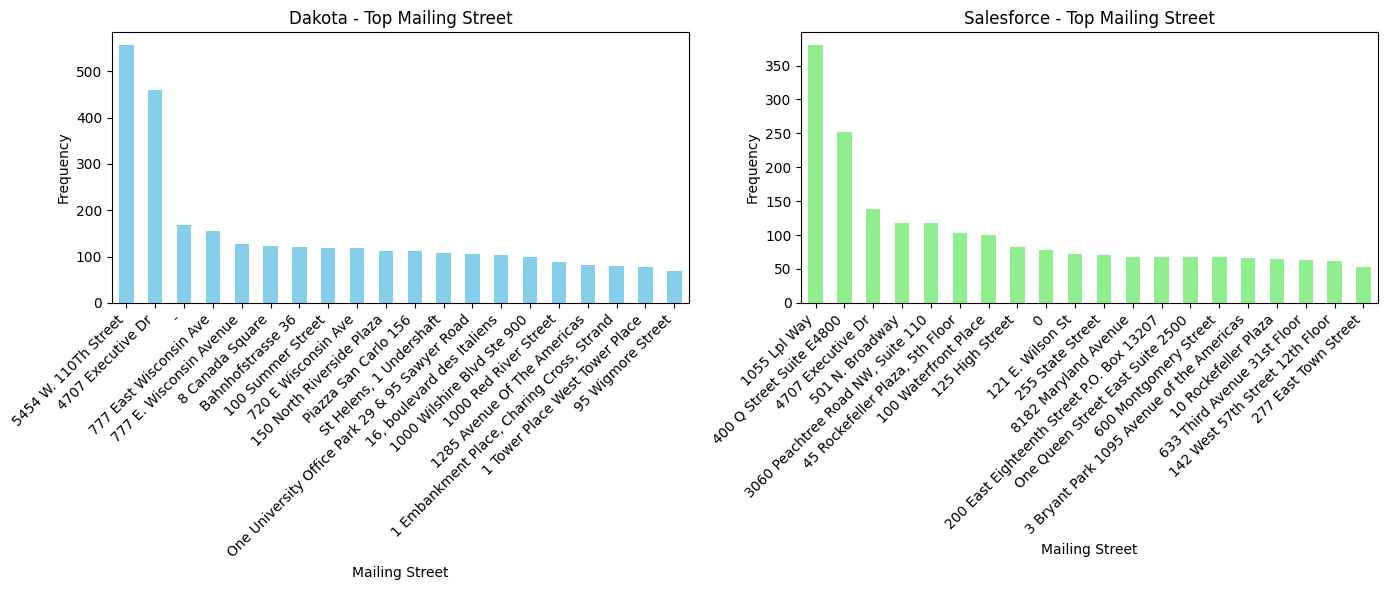

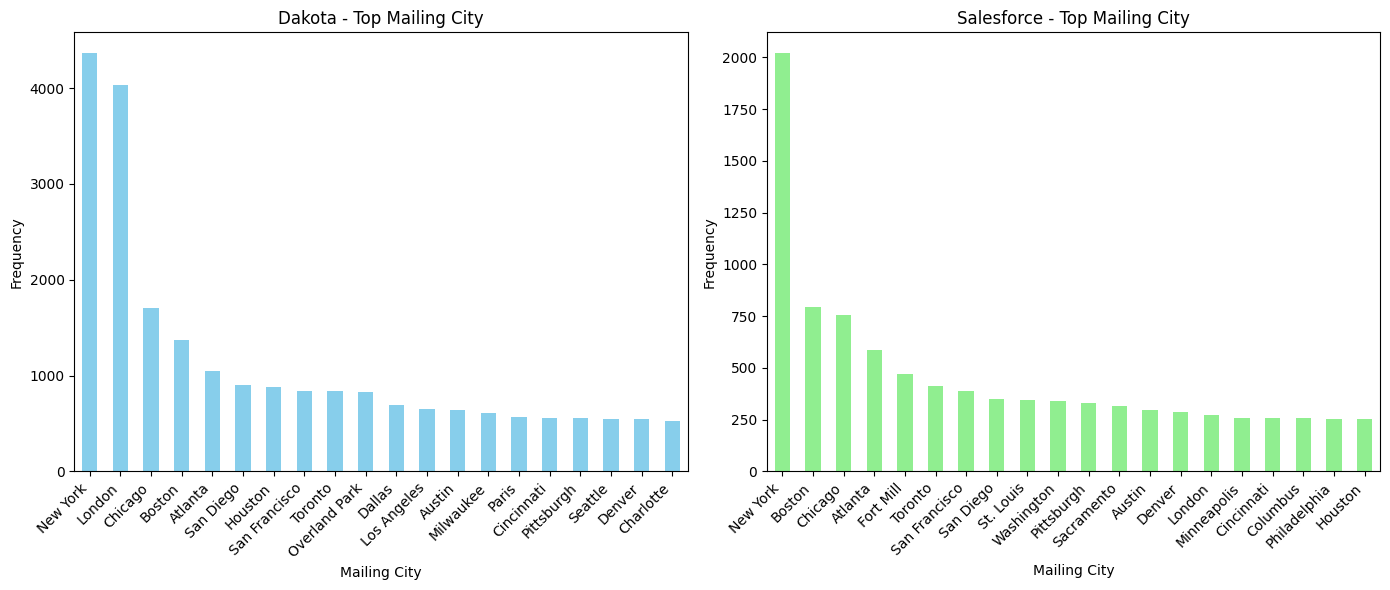

No data to plot for column: wirehouse_group


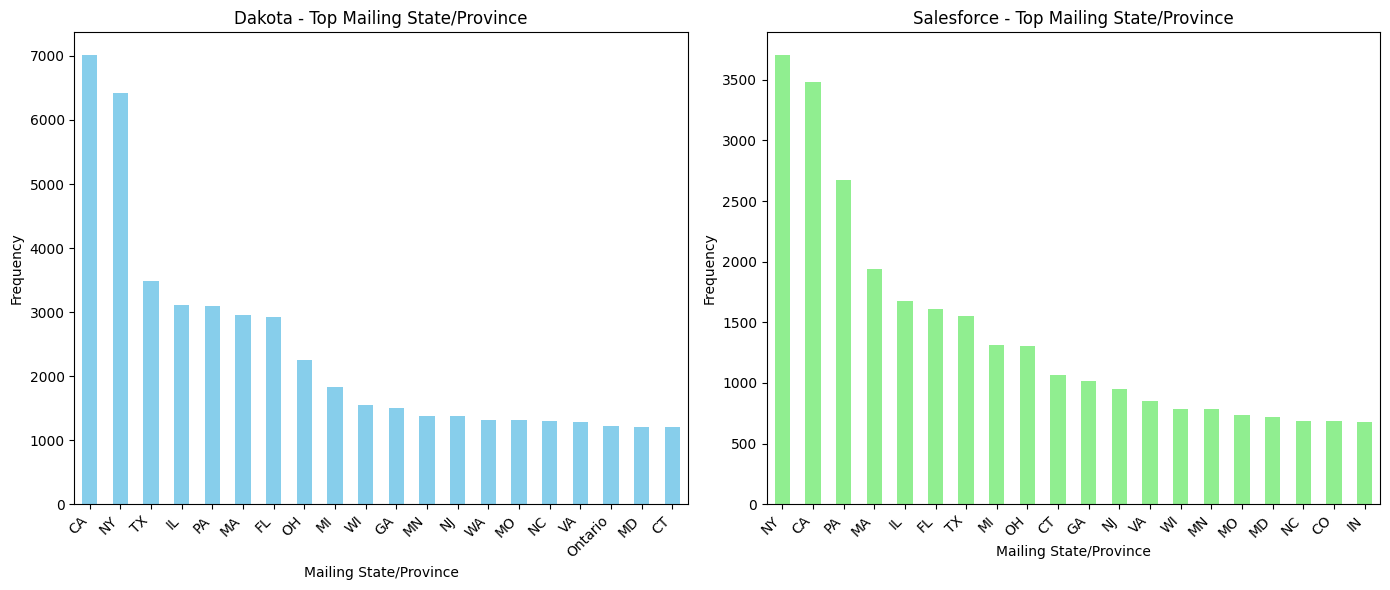

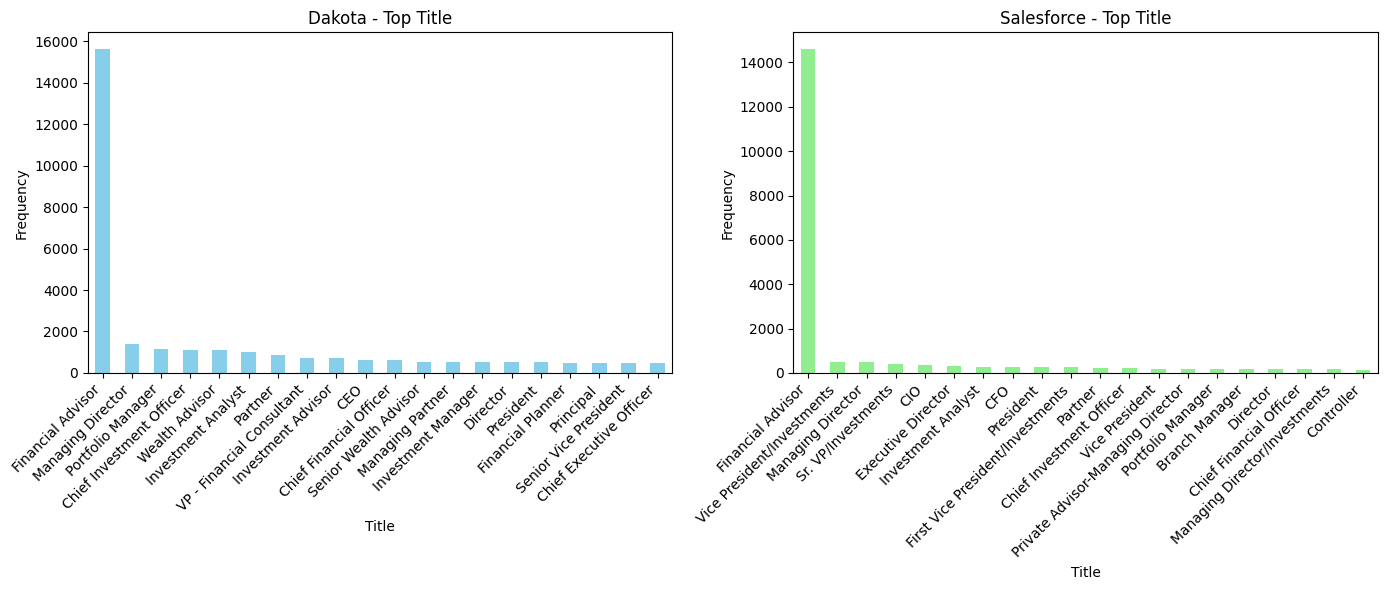

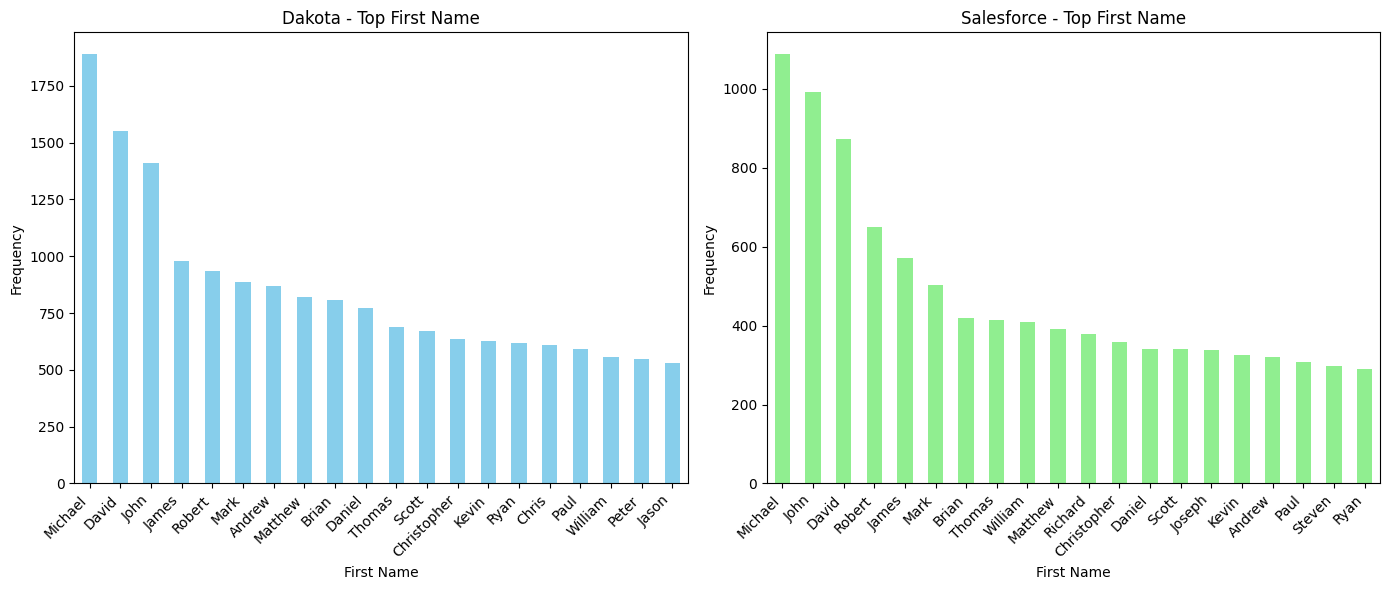

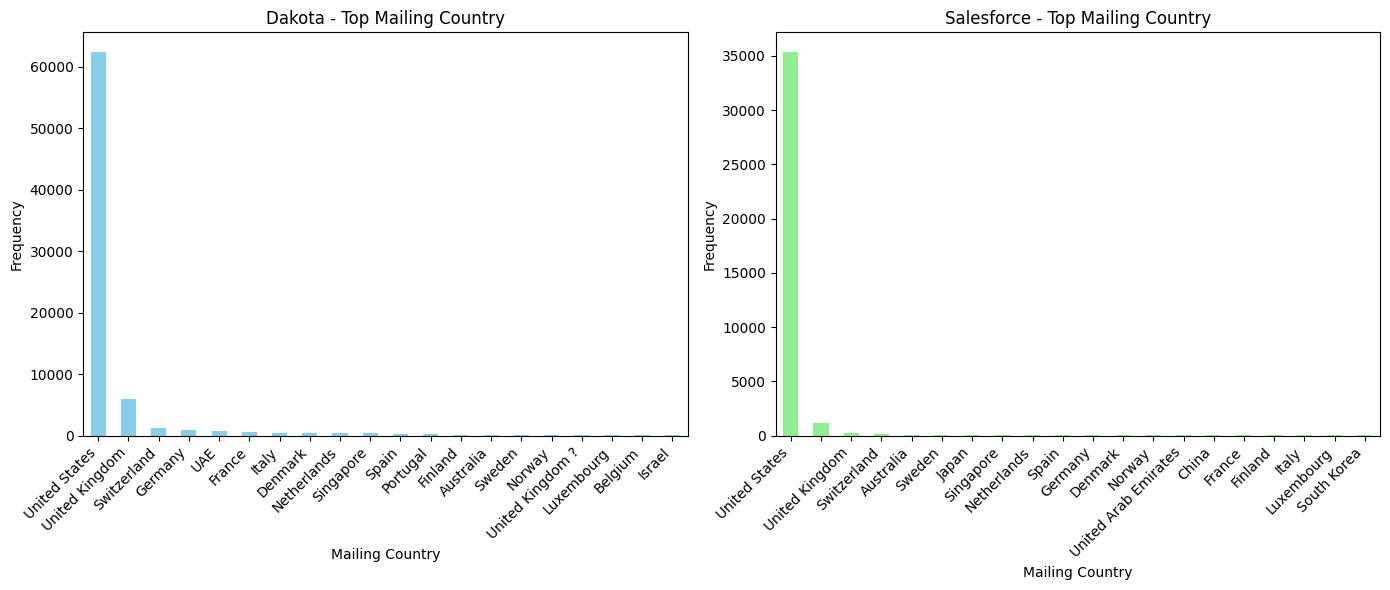

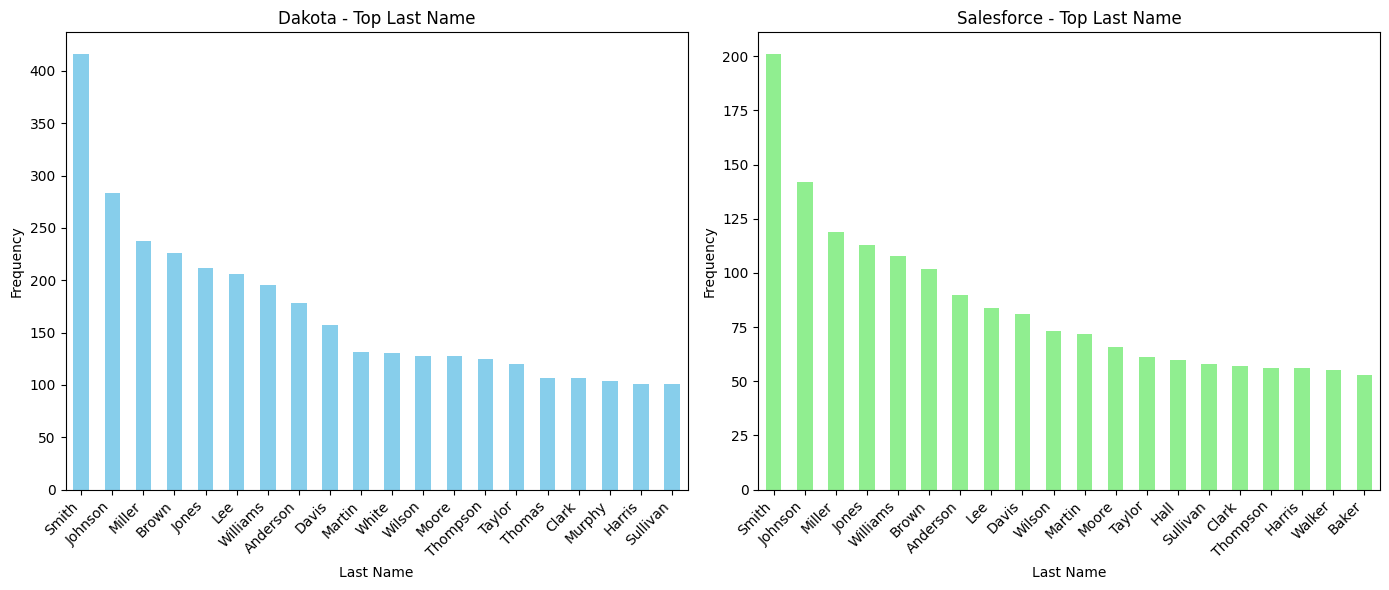

In [85]:
# --- Metadata Comparison ---
def compare_metadata(df1, df2, df1_name, df2_name):
    print(f"--- {df1_name} Info ---")
    print(df1.info())
    print(df1.describe(include='all'))
    print("\n")

    print(f"--- {df2_name} Info ---")
    print(df2.info())
    print(df2.describe(include='all'))
    print("\n")

    # Compare column sets
    df1_cols = set(df1.columns)
    df2_cols = set(df2.columns)

    print(f"Columns in {df1_name} but not in {df2_name}: {df1_cols - df2_cols}")
    print(f"Columns in {df2_name} but not in {df1_name}: {df2_cols - df1_cols}")
    print(f"Common columns: {df1_cols & df2_cols}")

def plot_column_distribution(df1, df2, column, df1_name, df2_name):
    df1_value_counts = df1[column].value_counts().head(20)
    df2_value_counts = df2[column].value_counts().head(20)

    if df1_value_counts.empty and df2_value_counts.empty:
        print(f"No data to plot for column: {column}")
        return

    plt.figure(figsize=(14, 6))

    if not df1_value_counts.empty:
        plt.subplot(1, 2, 1)
        df1_value_counts.plot(kind='bar', color='skyblue')
        plt.title(f'{df1_name} - Top {column}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')

    if not df2_value_counts.empty:
        plt.subplot(1, 2, 2)
        df2_value_counts.plot(kind='bar', color='lightgreen')
        plt.title(f'{df2_name} - Top {column}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage:
compare_metadata(dakota_non_wirehouse_df, salesforce_non_wirehouse_df, "Dakota Non-Wirehouse", "Salesforce Non-Wirehouse")

# Plot comparisons for shared columns
shared_columns = set(dakota_non_wirehouse_df.columns) & set(salesforce_non_wirehouse_df.columns)
for col in shared_columns:
    if dakota_non_wirehouse_df[col].dtype == 'object':
        plot_column_distribution(dakota_non_wirehouse_df, salesforce_non_wirehouse_df, col, "Dakota", "Salesforce")


# Field Matching
Dakota
 0   ContactID                    76461 non-null  object - not in salesforce        
 1   First Name                   76431 non-null  object - First Name
 2   Last Name                    76461 non-null  object - Last Name
 3   Email                        76460 non-null  object - Email
 4   Account ID (Case Safe)       76461 non-null  object - not in salesforce
 5   Account Name                 76461 non-null  object - Company Name
 6   Metro Area: Metro Area Name  76439 non-null  object - not in salesforce but derivable from city
 7   Phone                        75640 non-null  object - Phone
 8   Title                        76457 non-null  object - Title
 9   Contact Type                 76453 non-null  object - very similar to title
 10  Asset Class Coverage         76438 non-null  object - unique Dakota
 11  Mailing Street               75938 non-null  object - same 
 12  Mailing City                 76441 non-null  object - same 
 13  Mailing State/Province       62511 non-null  object - same 
 14  Mailing Zip/Postal Code      75830 non-null  object - same 
 15  Mailing Country              76456 non-null  object - same 
 16  Biography                    28665 non-null  object - text about their background
 17  CRD #                        30611 non-null  object - not in salesforce
 18  Last Modified DateTime       76461 non-null  object - not needed
 19  Created DateTime             76461 non-null  object - not needed
 20  Unnamed: 20                  1 non-null      object - N/A
 21  wirehouse_group              0 non-null      object - N/A

Salesforce
---  ------                   --------------  ----- 
 0   Salutation               3 non-null      object - Not in Dakota and many empty 
 1   First Name               37523 non-null  object - same
 2   Last Name                37629 non-null  object - same
 3   Title                    35354 non-null  object - same
 4   Company Name             37629 non-null  object - Account Name
 5   Mailing Street           27010 non-null  object - same 
 6   Mailing City             36202 non-null  object - same 
 7   Mailing State/Province   35350 non-null  object - same 
 8   Mailing Zip/Postal Code  15551 non-null  object - same 
 9   Mailing Country          36343 non-null  object - same 
 10  Phone                    31198 non-null  object - same
 11  Fax                      10095 non-null  object - not in Dakota
 12  Mobile                   5 non-null      object - not in Dakota
 13  Email                    37628 non-null  object - same
 14  Company Owner            37629 non-null  object - if not existing, make it Rockefeller Asset Management? 
 15  wirehouse_group          0 non-null      object - N/A 

 New DB
---  ------                   --------------  ----- 
0 First Name
1 Last Name
2 Title
3 Company Name (merge with account name)
4 Email
5 Mailing Street
6 Mailing City
7 Mailing State/Province
8 Mailing Zip/Postal Code
9 Mailing Country 
10 Phone
11 Company Owner

In [86]:
# Standardize emails
salesforce_non_wirehouse_df['Email'] = salesforce_non_wirehouse_df['Email'].str.strip().str.lower()
dakota_non_wirehouse_df['Email'] = dakota_non_wirehouse_df['Email'].str.strip().str.lower()

# Rename 'Account Name' in Dakota to 'Company Name' to standardize BEFORE merging
if 'Account Name' in dakota_non_wirehouse_df.columns:
    dakota_non_wirehouse_df = dakota_non_wirehouse_df.rename(columns={'Account Name': 'Company Name'})

# Drop rows with missing emails
salesforce_non_wirehouse_df = salesforce_non_wirehouse_df.dropna(subset=['Email'])
dakota_non_wirehouse_df = dakota_non_wirehouse_df.dropna(subset=['Email'])

# Check how many NaNs existed before the merge
print("🔍 Missing values in Salesforce before merge:")
print(salesforce_non_wirehouse_df.isna().sum())

print("🔍 Missing values in Dakota before merge:")
print(dakota_non_wirehouse_df.isna().sum())

# Count and show duplicates before dropping
print("📌 Salesforce duplicate emails before dropping:",
      salesforce_non_wirehouse_df.duplicated(subset='Email').sum())
print("📌 Dakota duplicate emails before dropping:",
      dakota_non_wirehouse_df.duplicated(subset='Email').sum())

# Drop duplicate emails
salesforce_non_wirehouse_df = salesforce_non_wirehouse_df.drop_duplicates(subset='Email')
dakota_non_wirehouse_df = dakota_non_wirehouse_df.drop_duplicates(subset='Email')

# Merge datasets on Email
merged = pd.merge(
    salesforce_non_wirehouse_df,
    dakota_non_wirehouse_df,
    on='Email',
    how='outer',
    suffixes=('_sf', '_dk')
)

# Check how many NaNs exist after the merge
print("🔍 Missing values in merged dataset:")
print(merged.isna().sum())

# Override Salesforce fields with Dakota where available
for col in ['First Name', 'Last Name', 'Title', 'Mailing Street', 'Mailing City',
            'Mailing State/Province', 'Mailing Zip/Postal Code', 'Mailing Country', 'Phone']:
    col_sf = f"{col}_sf"
    col_dk = f"{col}_dk"
    merged[col] = merged.get(col_dk, pd.Series(index=merged.index)).combine_first(
                  merged.get(col_sf, pd.Series(index=merged.index)))

merged['Company Name'] = merged.get('Company Name_dk', pd.Series(index=merged.index)).combine_first(
                         merged.get('Company Name_sf', pd.Series(index=merged.index)))

# Capitalize company names
merged['Company Name'] = merged['Company Name'].str.title()


# Use Salesforce's Company Owner if available
merged['Company Owner'] = merged.get('Company Owner_sf', pd.Series(index=merged.index))

# Analytics
total_contacts = len(merged)
new_contacts = merged['Email'].isin(dakota_non_wirehouse_df['Email']) & ~merged['Email'].isin(salesforce_non_wirehouse_df['Email'])
num_new_contacts = new_contacts.sum()
coverage_pct = 100 * (1 - num_new_contacts / len(dakota_non_wirehouse_df))

print(f"📊 Total contacts after merge: {total_contacts}")
print(f"🆕 New contacts acquired from Dakota: {num_new_contacts}")
print(f"✅ Dakota contacts already covered: {coverage_pct:.2f}%")

# Final DataFrame
final_columns = ['First Name', 'Last Name', 'Title', 'Company Name', 'Email',
                 'Mailing Street', 'Mailing City', 'Mailing State/Province',
                 'Mailing Zip/Postal Code', 'Mailing Country', 'Phone', 'Company Owner']
final_df = merged[final_columns]

# Preview
print(final_df.head())


🔍 Missing values in Salesforce before merge:
Salutation                 37625
First Name                   106
Last Name                      0
Title                       2275
Company Name                   0
Mailing Street             10619
Mailing City                1427
Mailing State/Province      2279
Mailing Zip/Postal Code    22078
Mailing Country                0
Phone                       6431
Fax                        27533
Mobile                     37623
Email                          0
Company Owner                  0
wirehouse_group            37628
dtype: int64
🔍 Missing values in Dakota before merge:
ContactID                          0
First Name                        30
Last Name                          0
Email                              0
Account ID (Case Safe)             0
Company Name                       0
Metro Area: Metro Area Name       22
Phone                            821
Title                              4
Contact Type                       8
Ass

# Dakota Owner Mapping + Off State

                           Company Name Mailing State/Province Company Owner  \
0          Korea Investment Corporation                    NaN           NaN   
1                 Nagle Wealth Partners                    NaN           NaN   
2  Electrical Workers, Ibew, Local #369                     KY            AG   
3                 Nagle Wealth Partners                    NaN           NaN   
4                 Nagle Wealth Partners                    NaN           NaN   

              OwnerID  
0                 NaN  
1                 NaN  
2  005a600000177CHAAY  
3                 NaN  
4                 NaN  


C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_24972\3318487546.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Company Owner'] = final_df.apply(
C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_24972\3318487546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['OwnerID'] = final_df['Company Owner'].map(team_ownerID_map)


In [88]:
# Export final_df to Excel
final_df.to_excel("../data/all_contacts/New_Salesforce_Merge.xlsx", index=False)


In [89]:
# Map team member codes back to full names
team_member_name_map = {
    'AG': 'Austin S. Gardner',
    'KH': 'Katherine H.',
    'AP': 'Alex T. Petrone',
    'MJ': 'Mark Juelis',
    'Rockefeller Asset Management': 'Rockefeller Asset Management'
}

# Replace Company Owner codes with full names
final_df['Company Owner'] = final_df['Company Owner'].map(team_member_name_map).fillna(final_df['Company Owner'])

# Export non-U.S.-based contacts to Excel
non_us_df = final_df[final_df['Mailing Country'].str.strip().str.lower() != 'united states']
non_us_df.to_excel("../data/all_contacts/Non_US_Contacts.xlsx", index=False)


C:\Users\MarkBogorad\AppData\Local\Temp\ipykernel_24972\1100030799.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Company Owner'] = final_df['Company Owner'].map(team_member_name_map).fillna(final_df['Company Owner'])
